In [11]:
pip install numpy

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.


In [4]:
import networkx as nx
import matplotlib.pyplot as plt
import torch
import random

def visualize_hetero_graph(graph):
    G = nx.Graph()

    # 添加用户节点
    for i in range(graph['user'].x.shape[0]):
        G.add_node(f'U{i}', bipartite=0)

    # 添加地点节点
    for i in range(graph['place'].x.shape[0]):
        G.add_node(f'P{i}', bipartite=1)

    # 添加边
    edge_index = graph['user', 'place'].edge_index
    for i in range(edge_index.shape[1]):
        user = f'U{edge_index[0, i].item()}'
        place = f'P{edge_index[1, i].item()}'
        G.add_edge(user, place)

    edge_attr = graph['user', 'place'].edge_attr
    weights = []
    for i in range(edge_index.shape[1]):
        weights.append(edge_attr[i].item())
    max_weight = max(weights)
    min_weight = min(weights)
    normalized_weights = [(w - min_weight) / (max_weight - min_weight) * 4 + 1 for w in weights]

    # 设置布局
    pos = nx.spring_layout(G, iterations=10, k=0.1)

    # 绘制节点
    plt.figure(figsize=(8, 8))
    nx.draw_networkx_nodes(G, pos, nodelist=[node for node in G.nodes() if node.startswith('U')], 
                           node_color='lightblue', node_size=300, label='Users')
    nx.draw_networkx_nodes(G, pos, nodelist=[node for node in G.nodes() if node.startswith('P')], 
                           node_color='lightgreen', node_size=300, label='Places')

    # 绘制边
    nx.draw_networkx_edges(G, pos, alpha=0.3, width=normalized_weights)

    # 添加标签
    labels = {node: node for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels, font_size=8)

    plt.title("Heterogeneous Graph: Users and Places")
    plt.legend()
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [6]:
import pandas as pd
import torch
from torch_geometric.data import HeteroData
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# 读取数据
df = pd.read_csv('D:/研究生/03Phd/segregation/shanghai/shanghai_weibo.csv', encoding='gbk')

# 对类别特征进行编码
le = LabelEncoder()
categorical_cols = ['city', 'gender', 'age_label', 'SES', 'category']
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

# 构建异构图
def build_hetero_graph(df):
    data = HeteroData()

    # 用户节点特征处理
    user_features = df.groupby('user_id')[['gender', 'age_label', 'SES']].first().reset_index()
    
    # One-hot 编码
    onehot_encoder = OneHotEncoder(sparse_output=False)
    user_onehot = onehot_encoder.fit_transform(user_features[['gender', 'age_label', 'SES']])
    data['user'].x = torch.tensor(user_onehot, dtype=torch.float)
    user_mapping = {id: i for i, id in enumerate(user_features['user_id'])}
    # 添加 node_id 属性
    data['user'].node_id = torch.arange(len(user_mapping), dtype=torch.long)

    # 地点节点特征处理
    place_features = df.groupby('place')[['lng', 'lat', 'category']].first().reset_index()
    category_onehot = onehot_encoder.fit_transform(place_features[['category']])
    # 组合经度、纬度和 category 的 one-hot 编码
    place_features_combined = np.hstack([
        place_features[['lng', 'lat']].values,
        category_onehot
    ])
    data['place'].x = torch.tensor(place_features_combined, dtype=torch.float)
    place_mapping = {place: i for i, place in enumerate(place_features['place'])}
    # 添加 node_id 属性
    data['place'].node_id = torch.arange(len(place_mapping), dtype=torch.long)

    # 计算边的权重（访问次数）
    edge_weights = df.groupby(['user_id', 'place']).size().reset_index(name='weight')
    edge_weights['user_index'] = edge_weights['user_id'].map(user_mapping)
    edge_weights['place_index'] = edge_weights['place'].map(place_mapping)

    # 归一化边的权重
    scaler = MinMaxScaler()
    edge_weights['normalized_weight'] = scaler.fit_transform(edge_weights[['weight']])

    # 用户-地点边
    user_indices = edge_weights['user_index'].tolist()
    place_indices = edge_weights['place_index'].tolist()

    data['user', 'place'].edge_index = torch.tensor([user_indices, place_indices], dtype=torch.long)
    data['user', 'place'].edge_attr = torch.tensor(edge_weights['normalized_weight'].values, dtype=torch.float)

    return data, user_features, place_features

graph, user_features, place_features = build_hetero_graph(df)

# visualize_hetero_graph(graph)

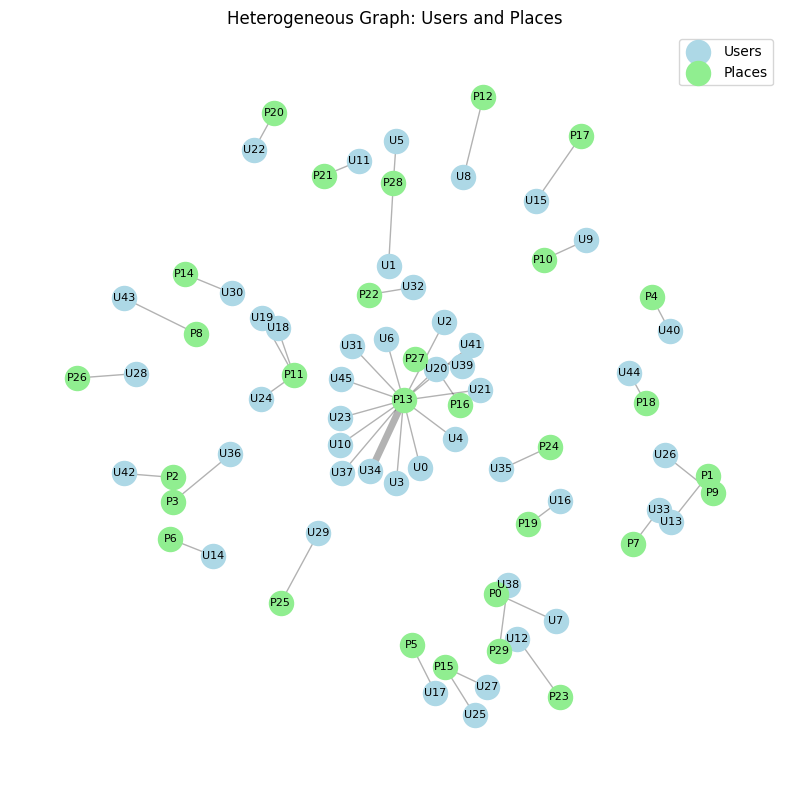

In [5]:
###visual samples
# visualize_hetero_graph(graph)

In [7]:
graph

HeteroData(
  user={
    x=[10752, 10],
    node_id=[10752],
  },
  place={
    x=[13721, 18],
    node_id=[13721],
  },
  (user, to, place)={
    edge_index=[2, 41331],
    edge_attr=[41331],
  }
)

In [8]:
import torch_geometric.transforms as T

to_undirected = T.ToUndirected()
graph = to_undirected(graph)

transform = T.RandomLinkSplit(
    num_val=0.1,  # 10% 的边用于验证
    num_test=0.1,  # 10% 的边用于测试
    disjoint_train_ratio=0.3,  # 70% 的边用于消息传递，30% 的边用于监督
    neg_sampling_ratio=2.0,  # 固定负样本的比例为 2:1
    add_negative_train_samples=True,  # 不在训练集中添加负样本
    edge_types=("user", "to", "place"),
    rev_edge_types=("place", "rev_to", "user"),
)

train_data, val_data, test_data = transform(graph)

In [9]:
train_data

HeteroData(
  user={
    x=[10752, 10],
    node_id=[10752],
  },
  place={
    x=[13721, 18],
    node_id=[13721],
  },
  (user, to, place)={
    edge_index=[2, 23146],
    edge_attr=[23146],
    edge_label=[29757],
    edge_label_index=[2, 29757],
  },
  (place, rev_to, user)={
    edge_index=[2, 23146],
    edge_attr=[23146],
  }
)

In [5]:
# from torch_geometric.loader import LinkNeighborLoader
# from torch_geometric.data import HeteroData

# # 定义种子边:
# edge_label_index = train_data["user", "to", "place"].edge_label_index
# edge_label = train_data["user", "to", "place"].edge_label

# # 使用 LinkNeighborLoader 并按照要求配置参数
# train_loader = LinkNeighborLoader(
#     data=train_data,  # 使用完整的异构图数据
#     num_neighbors=[20, 10],  # 第一跳采样最多 20 个邻居，第二跳采样最多 10 个邻居
#     neg_sampling_ratio=2.0,  # 负采样比例为 2:1
#     edge_label_index=(("user", "to", "place"), edge_label_index),
#     edge_label=edge_label,
#     batch_size=128,  # 每个批次的样本数量
#     shuffle=True,  # 是否随机打乱数据
# )

HeteroConv
HGTConv
HEATConv
HANConv
RGCNConv

### GNN模块

In [10]:
import torch
import torch.nn.functional as F
from torch import Tensor
from torch_geometric.nn import SAGEConv, GATConv, HeteroConv, HGTConv, RGCNConv, HANConv, GraphConv, to_hetero
from torch_geometric.data import HeteroData

class SAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, dropout=0.2):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.dropout = torch.nn.Dropout(dropout)
    
    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, dropout=0.2):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, add_self_loops=False, dropout=dropout)
        self.conv2 = GATConv(hidden_channels, hidden_channels, add_self_loops=False, dropout=dropout)
    
    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

class Hetero(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, metadata, dropout=0.2):
        super().__init__()
        self.conv1 = HeteroConv({
            edge_type: SAGEConv((-1, -1), hidden_channels)
            for edge_type in metadata[1]
        })
        self.conv2 = HeteroConv({
            edge_type: SAGEConv((-1, -1), hidden_channels)
            for edge_type in metadata[1]
        })
        self.dropout = torch.nn.Dropout(dropout)
    
    def forward(self, x_dict, edge_index_dict):
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {key: F.relu(self.dropout(x)) for key, x in x_dict.items()}
        x_dict = self.conv2(x_dict, edge_index_dict)
        return x_dict

class HGT(torch.nn.Module):
    def __init__(self, hidden_channels, num_heads, num_layers, metadata, dropout=0.2):
        super().__init__()
        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HGTConv(hidden_channels, hidden_channels, metadata, num_heads)
            self.convs.append(conv)
        self.lins = torch.nn.ModuleDict({
            node_type: torch.nn.Linear(hidden_channels, hidden_channels)
            for node_type in metadata[0]
        })
        self.dropout = torch.nn.Dropout(dropout)
    
    def forward(self, x_dict, edge_index_dict):
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {key: F.relu(self.dropout(x)) for key, x in x_dict.items()}
        return {node_type: self.lins[node_type](x) for node_type, x in x_dict.items()}

class RGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_layers, num_relations, dropout=0.2):
        super().__init__()
        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = RGCNConv(in_channels, hidden_channels, num_relations)
            self.convs.append(conv)
        self.lin = torch.nn.Linear(hidden_channels, hidden_channels)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x, edge_index, edge_type):
        for conv in self.convs:
            x = conv(x, edge_index, edge_type)
            x = F.relu(self.dropout(x))
        return self.lin(x)

class HAN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, metadata, dropout=0.2):
        super().__init__()
        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HANConv(in_channels, hidden_channels, metadata, heads=4, dropout=dropout)
            self.convs.append(conv)
        self.lin = torch.nn.Linear(hidden_channels, out_channels)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x_dict, edge_index_dict):
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {key: F.relu(self.dropout(x)) for key, x in x_dict.items()}
        return {key: self.lin(x) for key, x in x_dict.items()}
    
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, dropout=0.5):
        super().__init__()
        self.conv1 = GraphConv(in_channels, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.dropout = torch.nn.Dropout(dropout)
    
    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

In [7]:
# class GCN(torch.nn.Module):
#     def __init__(self, in_channels, hidden_channels, dropout=0.2):
#         super().__init__()
#         self.conv1 = GraphConv(in_channels, hidden_channels)
#         self.conv2 = GraphConv(hidden_channels, hidden_channels)
#         self.dropout = torch.nn.Dropout(dropout)

#     def forward(self, x: Tensor, edge_index: Tensor, edge_attr: Tensor) -> Tensor:
#         x = self.conv1(x, edge_index, edge_attr)
#         x = F.relu(x)
#         x = self.dropout(x)
#         x = self.conv2(x, edge_index, edge_attr)
#         return x

In [11]:
class Model(torch.nn.Module):
    def __init__(self, graph: HeteroData, hidden_channels, out_channels, gnn_type='SAGE', num_layers=2):
        super().__init__()
        self.hidden_channels = hidden_channels

        self.node_embeddings = torch.nn.ModuleDict()
        for node_type in graph.node_types:
            num_nodes = graph[node_type].num_nodes
            self.node_embeddings[node_type] = torch.nn.Embedding(num_nodes, hidden_channels)

        self.node_transforms = torch.nn.ModuleDict()
        for node_type in graph.node_types:
            if hasattr(graph[node_type], 'x'):
                in_channels = graph[node_type].x.size(1)
                self.node_transforms[node_type] = torch.nn.Linear(in_channels, hidden_channels)

        if gnn_type == 'SAGE':
            self.gnn = to_hetero(SAGE(hidden_channels, hidden_channels), graph.metadata())
        elif gnn_type == 'GAT':
            self.gnn = to_hetero(GAT(hidden_channels, hidden_channels), graph.metadata())
        elif gnn_type == 'Hetero':
            self.gnn = Hetero(hidden_channels, hidden_channels, graph.metadata())
        elif gnn_type == 'HGT':
            self.gnn = HGT(hidden_channels, num_heads=4, num_layers=num_layers, metadata=graph.metadata())
        elif gnn_type == 'RGCN':
            num_relations = len(graph.edge_types)
            self.gnn = RGCN(hidden_channels, hidden_channels, num_layers, num_relations)
        elif gnn_type == 'HAN':
            self.gnn = HAN(hidden_channels, hidden_channels, out_channels, num_layers, graph.metadata())
        elif gnn_type == 'GCN':
            self.gnn = to_hetero(GCN(hidden_channels, hidden_channels), graph.metadata())

        self.classifier = torch.nn.Linear(hidden_channels * 2, 1)

    def forward(self, graph: HeteroData) -> Tensor:
        x_dict = {}
        for node_type in graph.node_types:
            x = self.node_embeddings[node_type](graph[node_type].node_id)
            if node_type in self.node_transforms:
                x = x + self.node_transforms[node_type](graph[node_type].x)
            x_dict[node_type] = x

        # edge_attr_dict = {edge_type: graph[edge_type].edge_attr
        #                         for edge_type in graph.edge_types}

        if isinstance(self.gnn, RGCN):
            edge_index, edge_type = self.prepare_edges(graph)
            x = torch.cat([x_dict[node_type] for node_type in graph.node_types])
            x = self.gnn(x, edge_index, edge_type)
            start = 0
            for node_type in graph.node_types:
                num_nodes = graph[node_type].num_nodes
                x_dict[node_type] = x[start:start+num_nodes]
                start += num_nodes
        else:
            # x_dict = self.gnn(x_dict, graph.edge_index_dict, edge_attr_dict)
            x_dict = self.gnn(x_dict, graph.edge_index_dict)


        user_x = x_dict['user']
        place_x = x_dict['place']
        edge_index = graph['user', 'to', 'place'].edge_label_index
        edge_feat = torch.cat([user_x[edge_index[0]], place_x[edge_index[1]]], dim=-1)
        return self.classifier(edge_feat).squeeze(-1)

    def prepare_edges(self, graph: HeteroData):
        edge_index_list = []
        edge_type_list = []
        for i, (src, edge_type, dst) in enumerate(graph.edge_types):
            edge_index = graph[src, edge_type, dst].edge_index
            edge_index_list.append(edge_index)
            edge_type_list.append(torch.full((edge_index.size(1),), i, dtype=torch.long))
        edge_index = torch.cat(edge_index_list, dim=1)
        edge_type = torch.cat(edge_type_list)
        return edge_index, edge_type

In [56]:
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import roc_curve, auc
import numpy as np

def train_model(model, train_data, optimizer, criterion, num_epochs=200):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    train_data = train_data.to(device)
    
    losses = []
    for epoch in range(1, num_epochs + 1):
        model.train()
        optimizer.zero_grad()
        pred = model(train_data)
        target = train_data["user", "to", "place"].edge_label
        loss = criterion(pred, target.float())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        losses.append(loss.item())
        
        if epoch % 10 == 0:
            print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    return losses, model

# 主循环
# gnn_types = ['SAGE', 'GAT', 'Hetero', 'HGT', 'RGCN', 'HAN', 'GCN']
gnn_types = ['SAGE']
all_losses = {}
all_models = {}

for gnn_type in gnn_types:
    print(f"Training {gnn_type} model...")
    model = Model(graph=train_data, hidden_channels=64, out_channels=64, gnn_type=gnn_type)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    criterion = torch.nn.BCEWithLogitsLoss()
    losses, trained_model = train_model(model, train_data, optimizer, criterion)
    all_losses[gnn_type] = losses
    all_models[gnn_type] = trained_model

Training SAGE model...
Epoch: 010, Loss: 0.8411
Epoch: 020, Loss: 0.6876
Epoch: 030, Loss: 0.6625
Epoch: 040, Loss: 0.6222
Epoch: 050, Loss: 0.6079
Epoch: 060, Loss: 0.5910
Epoch: 070, Loss: 0.5790
Epoch: 080, Loss: 0.5660
Epoch: 090, Loss: 0.5496
Epoch: 100, Loss: 0.5320
Epoch: 110, Loss: 0.5128
Epoch: 120, Loss: 0.5011
Epoch: 130, Loss: 0.4856
Epoch: 140, Loss: 0.4729
Epoch: 150, Loss: 0.4612
Epoch: 160, Loss: 0.4489
Epoch: 170, Loss: 0.4566
Epoch: 180, Loss: 0.4519
Epoch: 190, Loss: 0.4351
Epoch: 200, Loss: 0.4350


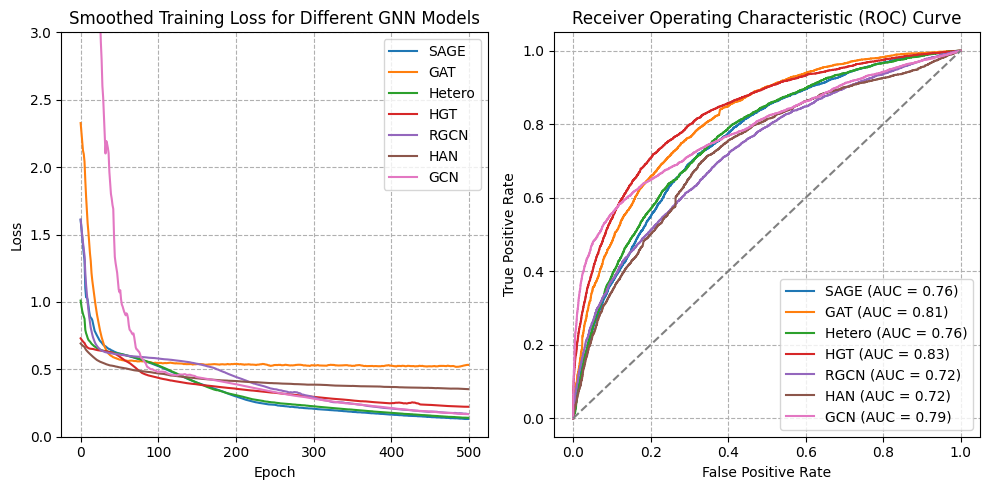

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def smooth_curve(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)

window_size = 10  # 移动平均窗口大小，可以根据需要调整
for gnn_type, losses in all_losses.items():
    losses_series = pd.Series(losses)
    smoothed_losses = losses_series.rolling(window=window_size, center=True, min_periods=1).mean()
    plt.plot(smoothed_losses, label=gnn_type)

plt.ylim(0, 3)  # 您可以根据需要调整这里的值
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Smoothed Training Loss for Different GNN Models')
plt.legend()
plt.grid(True, linestyle="--")

# 计算和绘制ROC曲线
plt.subplot(1, 2, 2)
for gnn_type, model in all_models.items():
    model.eval()
    with torch.no_grad():
        pred = model(test_data)
        target = test_data["user", "to", "place"].edge_label
        pred_np = pred.cpu().numpy()
        target_np = target.cpu().numpy()
        
        fpr, tpr, _ = roc_curve(target_np, pred_np)
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, label=f'{gnn_type} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True, linestyle="--")

plt.tight_layout()
plt.show()

## 隔离分析

In [35]:
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
import torch
import numpy as np

def test(model, data):
    model.eval()
    with torch.no_grad():
        pred = model(data)
        pred = pred.cpu().numpy()
        target = data["user", "to", "place"].edge_label.cpu().numpy()
        
        # 将预测概率转换为二元预测
        pred_binary = (pred > 0).astype(int)
        
        # 计算 AUC
        auc = roc_auc_score(target, pred)
        
        # 计算 Accuracy
        acc = accuracy_score(target, pred_binary)
        
        # 计算 F1 分数
        f1 = f1_score(target, pred_binary)
        
        print(f"AUC: {auc:.4f}")
        print(f"Accuracy: {acc:.4f}")
        print(f"F1 Score: {f1:.4f}")
        
        return auc, acc, f1

# 在训练循环之后，您可以这样使用测试函数
model.eval()
print("Test set results:")
test(model, test_data)

Test set results:
AUC: 0.8590
Accuracy: 0.7963
F1 Score: 0.6131


(0.8589665372083521, 0.7962738930558916, 0.6130514705882353)

In [36]:
import tqdm
import torch
from sklearn.metrics import roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# 收集所有用户与地点之间的连接概率和边索引
user_place_probs = []
all_edge_index = []

with torch.no_grad():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    sampled_data = train_data.to(device)
    pred = model(sampled_data)
    user_place_probs.append(pred.sigmoid())  # 转换为概率
    all_edge_index.append(sampled_data['user', 'to', 'place'].edge_index)

all_probs = torch.cat(user_place_probs, dim=0).cpu().numpy()
all_edge_index = torch.cat(all_edge_index, dim=1).cpu().numpy()

#####################
# 计算每个用户的隔离指数
user_probs = defaultdict(list)
for (u, p), prob in zip(all_edge_index.T, all_probs):
    user_probs[u].append(prob)

user_segregation_indices = {}
for user, probs in user_probs.items():
    user_segregation_indices[user] = np.median(probs)

#####################
# 计算每个地点的隔离指数
place_probs = defaultdict(list)
for (u, p), prob in zip(all_edge_index.T, all_probs):
    place_probs[p].append(prob)

place_segregation_indices = {}
for place, probs in place_probs.items():
    # 使用方差作为隔离指数，你也可以选择其他度量
    place_segregation_indices[place] = np.median(probs)


######################
# 还原用户编码########
user_decoder = dict(zip(user_features.index, user_features['user_id']))
user_segregation_df = pd.DataFrame({
    'user_id': [user_decoder[u] for u in user_segregation_indices.keys()],
    'integration_index': list(user_segregation_indices.values())
})

# 还原地点编码########
# 还原地点编码并添加坐标和类别
place_decoder = dict(zip(place_features.index, place_features['place']))
place_segregation_df = pd.DataFrame({
    'place': [place_decoder[p] for p in place_segregation_indices.keys()],
    'integration_index': list(place_segregation_indices.values())
})

# 计算每个地点的平均连接强度
place_avg_connection = {place: np.mean(probs) for place, probs in place_probs.items()}
place_avg_connection_df = pd.DataFrame({
    'place': [place_decoder[p] for p in place_avg_connection.keys()],
    'avg_connection_strength': list(place_avg_connection.values())
})

# 合并地点的隔离指数和平均连接强度
place_result_df = pd.merge(place_segregation_df, place_avg_connection_df, on='place')

# 添加坐标和类别信息
place_info = place_features.set_index('place')[['lng', 'lat', 'category']]
place_result_df = pd.merge(place_result_df, place_info, left_on='place', right_index=True)

# 重新排列列的顺序，使坐标和类别紧跟在地点名称之后
place_result_df = place_result_df[['place', 'lng', 'lat', 'category', 'integration_index', 'avg_connection_strength']]

# 如果类别是编码过的，需要解码
if 'category' in categorical_cols:
    category_decoder = dict(zip(range(len(le.classes_)), le.classes_))
    place_result_df['category'] = place_result_df['category'].map(category_decoder)


##################
# 保存隔离指数到CSV
user_segregation_df.to_csv('user_segregation_indices.csv', index=False)
place_result_df.to_csv('place_segregation_and_connection.csv', index=False)

print("用户隔离指数已保存到 'user_segregation_indices.csv'")
print("地点隔离指数和平均连接强度已保存到 'place_segregation_and_connection.csv'")

用户隔离指数已保存到 'user_segregation_indices.csv'
地点隔离指数和平均连接强度已保存到 'place_segregation_and_connection.csv'


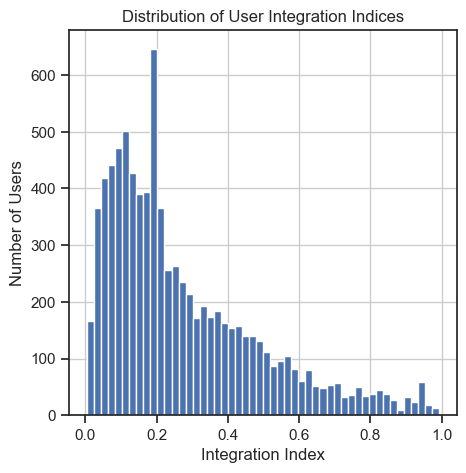

Average Integration Index: 0.2740
Median Integration Index: 0.2022
Min Integration Index: 0.0045
Max Integration Index: 0.9937
User with highest segregation index: 7993, Index: 0.9937
User with lowest segregation index: 6250, Index: 0.0045


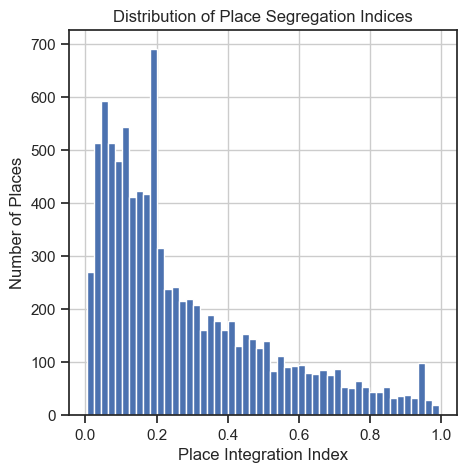

Average Place Integration Index: 0.2803
Median Place Integration Index: 0.1972
Min Place Integration Index: 0.0045
Max Place Integration Index: 0.9943
Place with highest Integration index: 9731, Index: 0.9943
Place with lowest Integration index: 1010, Index: 0.0045


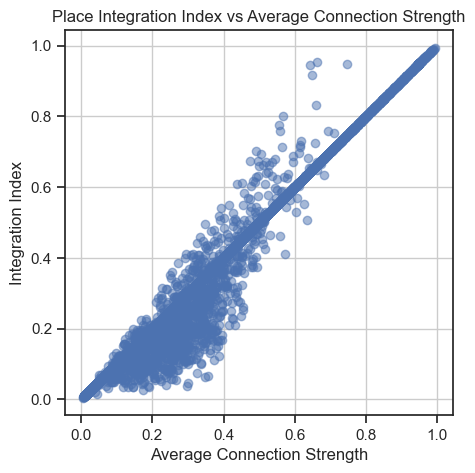

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# 可视化结果
plt.figure(figsize=(5, 5))
plt.hist(list(user_segregation_indices.values()), bins=50)
plt.xlabel('Integration Index')
plt.ylabel('Number of Users')
plt.title('Distribution of User Integration Indices')
plt.grid(True)
plt.show()

# 打印一些统计信息
indices = list(user_segregation_indices.values())
print(f"Average Integration Index: {np.mean(indices):.4f}")
print(f"Median Integration Index: {np.median(indices):.4f}")
print(f"Min Integration Index: {np.min(indices):.4f}")
print(f"Max Integration Index: {np.max(indices):.4f}")

# 找出隔离指数最高和最低的用户
max_segregation_user = max(user_segregation_indices, key=user_segregation_indices.get)
min_segregation_user = min(user_segregation_indices, key=user_segregation_indices.get)

print(f"User with highest segregation index: {max_segregation_user}, Index: {user_segregation_indices[max_segregation_user]:.4f}")
print(f"User with lowest segregation index: {min_segregation_user}, Index: {user_segregation_indices[min_segregation_user]:.4f}")

# 可视化地点隔离指数的分布
plt.figure(figsize=(5, 5))
plt.hist(list(place_segregation_indices.values()), bins=50)
plt.xlabel('Place Integration Index')
plt.ylabel('Number of Places')
plt.title('Distribution of Place Segregation Indices')
plt.grid(True)
plt.show()

# 打印统计信息
indices = list(place_segregation_indices.values())
print(f"Average Place Integration Index: {np.mean(indices):.4f}")
print(f"Median Place Integration Index: {np.median(indices):.4f}")
print(f"Min Place Integration Index: {np.min(indices):.4f}")
print(f"Max Place Integration Index: {np.max(indices):.4f}")

# 找出隔离指数最高和最低的地点
max_segregation_place = max(place_segregation_indices, key=place_segregation_indices.get)
min_segregation_place = min(place_segregation_indices, key=place_segregation_indices.get)

print(f"Place with highest Integration index: {max_segregation_place}, Index: {place_segregation_indices[max_segregation_place]:.4f}")
print(f"Place with lowest Integration index: {min_segregation_place}, Index: {place_segregation_indices[min_segregation_place]:.4f}")

# 分析隔离指数和平均连接强度的关系
plt.figure(figsize=(5, 5))
plt.scatter(list(place_avg_connection.values()), list(place_segregation_indices.values()), alpha=0.5)
plt.xlabel('Average Connection Strength')
plt.ylabel('Integration Index')
plt.title('Place Integration Index vs Average Connection Strength')
plt.grid(True)
plt.show()

In [30]:
place_avg_connection

{12325: 0.39452654,
 11781: 0.3531519,
 11894: 0.41529816,
 9987: 0.3030438,
 5292: 0.36768854,
 8575: 0.3443365,
 7864: 0.45109344,
 13145: 0.41647735,
 6804: 0.29284525,
 12112: 0.9474393,
 9611: 0.70854765,
 2842: 0.5427558,
 12852: 0.35409167,
 10711: 0.3699982,
 5309: 0.3627212,
 10975: 0.24636771,
 4177: 0.17233002,
 9458: 0.35882235,
 6801: 0.2727575,
 12783: 0.41294897,
 8848: 0.43584424,
 5460: 0.59478086,
 4613: 0.56861484,
 11365: 0.61167645,
 1074: 0.27095658,
 937: 0.34268403,
 5917: 0.79804087,
 3804: 0.32735205,
 11093: 0.33710626,
 5333: 0.46457323,
 6745: 0.3305489,
 6272: 0.36408162,
 6523: 0.4630896,
 4607: 0.4072046,
 12266: 0.37591505,
 4098: 0.7971649,
 2406: 0.35866627,
 13538: 0.41297358,
 5890: 0.3919159,
 11616: 0.41923124,
 7612: 0.54283035,
 12065: 0.26292425,
 2282: 0.45681152,
 7190: 0.87688786,
 4487: 0.43478298,
 12314: 0.49340448,
 3942: 0.42115906,
 3259: 0.6720682,
 6749: 0.40128005,
 35: 0.5708046,
 4441: 0.7740604,
 649: 0.5296789,
 9881: 0.8957268,

In [38]:
import pandas as pd 

df = pd.read_csv(r'D:\Coding\segaration_research\place_segregation_and_connection.csv', encoding='utf-8')
df

,place,lng,lat,category,integration_index,avg_connection_strength
0,金桥,121.596687,31.255988,Address Information,0.271091,0.330239
1,西岸凤巢AI PLAZA,121.455807,31.165441,Commercial Buildings,0.176345,0.267845
2,读者书店(外滩旗舰店),121.481181,31.238862,Dining Services,0.166391,0.255464
3,瓦肆 VAS SHANGHAI,121.428506,31.237708,Dining Services,0.188178,0.288062
4,外滩,121.483413,31.247297,Tourist Attractions,0.194644,0.291002
...,...,...,...,...,...,...
9381,nod coffee,121.444932,31.249916,Dining Services,0.104971,0.104971
9382,金色米兰苑,121.617676,31.277524,Real Estate Communities,0.095168,0.095168
9383,Peets Coffee皮爷咖啡(陆家嘴中心LG店),121.511878,31.233849,Dining Services,0.097788,0.097788
9384,誉八仙,121.467069,31.245900,Dining Services,0.218029,0.218029


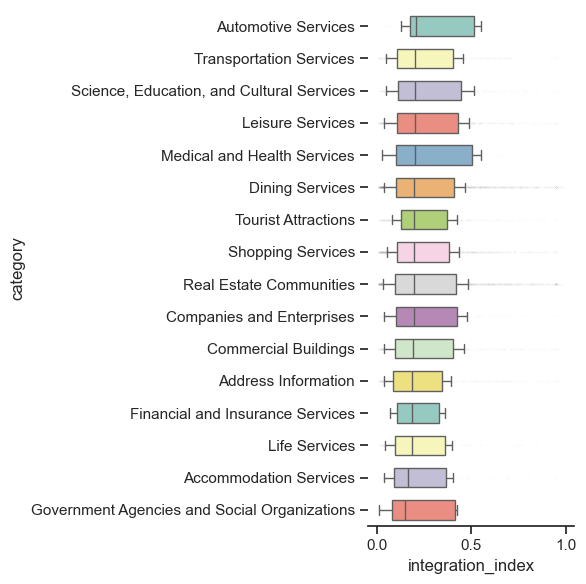

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks")
palette = sns.color_palette('Set3')

# df = df[df['integration_index'].ne(0) & df['integration_index'].ne(1)]
# q_low = df['integration_index'].quantile(0.05)
# q_hi = df['integration_index'].quantile(0.95)
# df_clean = df[(df['integration_index'] > q_low) & (df['integration_index'] < q_hi)]

# 计算每个标签的中位数，并按中位数从大到小排序
median_values = (
    df.groupby("category")["integration_index"]
    .median()
    .reset_index()
    .sort_values(by="integration_index", ascending=False)
)

# 将原数据框中的标签列转化为有序类别，按中位数排序
df["category"] = pd.Categorical(
    df["category"], 
    categories=median_values["category"], 
    ordered=True
)

# 按标签排序数据框
filtered_df_sorted = df.sort_values(by="category")

g = sns.catplot(
    data=filtered_df_sorted, 
    kind='box',
    x="integration_index", 
    y="category",  
    errorbar="ci", 
    # alpha=.8,
    height=6, 
    aspect=1,
    palette=palette,
    width=0.6,
    whis=0.2,
    fliersize=0.01
)
# plt.xlabel('Experience Diversity of Places', fontsize=12)
g.despine(left=True)
# plt.savefig("./fig5.jpg", dpi=600, bbox_inches='tight')